Павел Кузнецов   
kaggle.com/risingdish

# Задача - предсказать рейтинг шоколада по его характеристикам

# Описание данных:    
*Company* - компания производитель   
*Specific Bean Origin* - географический регион происхождения   
*REF* - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)   
*Review* - дата публикации отзыва   
*Cocoa Percent* - процентное содержание какао   
*Company Location* - страна производитель   
*Rating* - экспертный рейтинг   
*Bean Type* - используемый сорт какао-бобов, если таковой имеется   
*Broad Bean Origin* - географический регион происхождения какао-бобов   

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import association_metrics as am
from catboost import CatBoostRegressor

In [2]:
random_state = 42

In [3]:
data = pd.read_csv(r'C:\Users\1\Desktop\Code\ml_yand_course\competition_chocolate\chocolate_train.csv')
test_final_submit = pd.read_csv(r'C:\Users\1\Desktop\Code\ml_yand_course\competition_chocolate\chocolate_test_new.csv')

In [4]:
data.head(3)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania


In [5]:
test_final_submit.head(3)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize


# Обзор данных, EDA

Выделим категориальные колонки в список

In [6]:
cat_columns = []
for col in data.columns:
    if data[col].dtype == 'object':
        cat_columns.append(col)

cat_columns

['Company',
 'Specific Bean Origin',
 'Cocoa Percent',
 'Company Location',
 'Bean Type',
 'Broad Bean Origin']

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [8]:
data.describe()

,REF,Review,Rating
count,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,3.176494
std,551.284249,2.922499,0.478948
min,5.000000,2006.000000,1.000000
25%,593.000000,2010.000000,2.750000
50%,1077.000000,2013.000000,3.250000
75%,1514.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


In [9]:
data.describe(include='object')

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1255,1254,1254
unique,376,762,40,58,38,84
top,Soma,Madagascar,70%,U.S.A.,,Venezuela
freq,35,39,461,521,628,144


In [10]:
data.duplicated().sum()

0

Как можно видеть, отсутсвующих значений почти нет, дубликатов нет, большая часть колонок категориальныя

Посмотрим на распределения числовых признаков

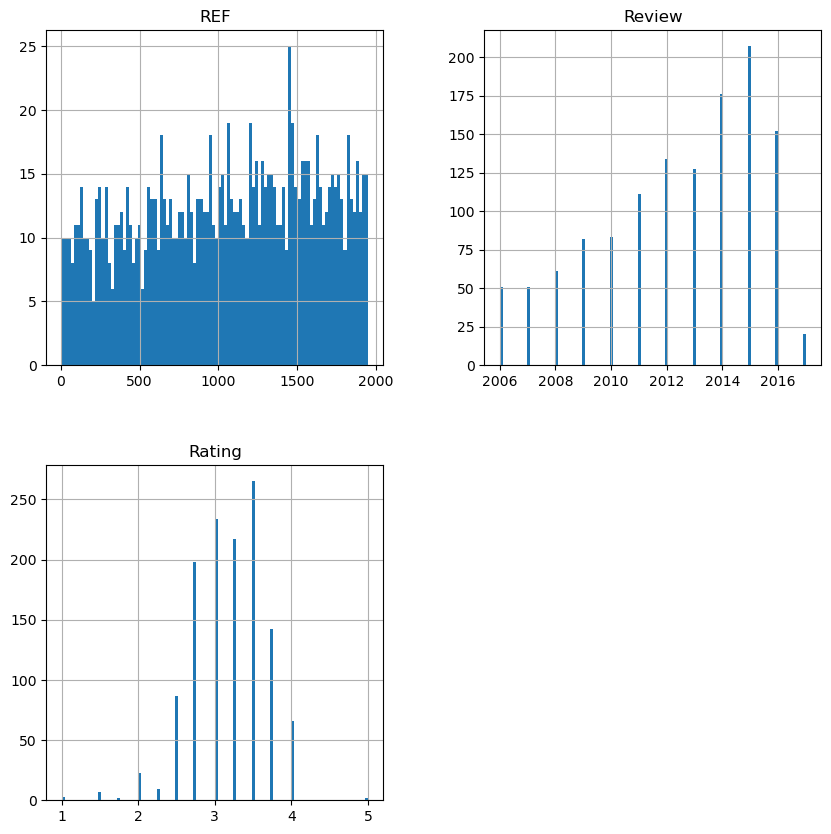

In [11]:
data.hist(bins=100, figsize=(10, 10));

Хорошие новости - распределение целевой переменной чем-то написмнает нормальное   
Плохие новости - очень мало наблюдений с оценкой выше 4, что может плохо сказаться на качестве, но на это мы повлиять не можем - это целевая переменная   
В остальном выбросов нет, в глаза бросается только то, что мало наблюдений за 2017 год, но это, возможно, объясняется тем, что данные в 2017 году и собирались, поэтому за этот год просто не успело собраться достаточно оценок

Также обращает на себя внимание, что в данных столбец процента является категориальной переменной, при этом в этих числах вполне есть смысл - 30% - это больше какао, чем 15%.   
Поэтому сделаем этот столбец числовым и посмотрим на его распределение

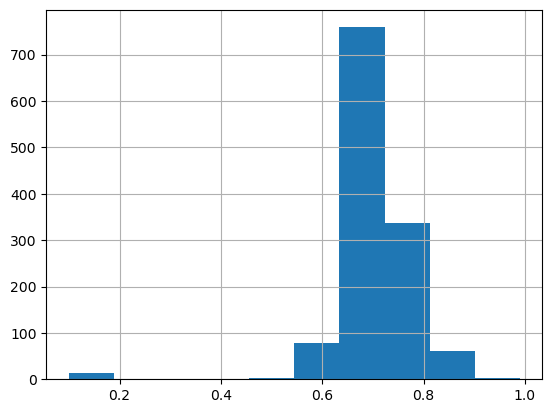

In [12]:
data['Cocoa Percent'] = data['Cocoa Percent'].apply(lambda x: int(x[:2]) / 100)
data['Cocoa Percent'].hist()
cat_columns.remove('Cocoa Percent')

Видно, что в основном процент какао в шоколаде 50-80, но есть сильные выбросы в меньшую сторону - меньше 20%.    
Это довольно ожидаемая картина, что шоколада с маленьким процентным содержанием какао-бобов меньше.    
Этот выброс информативен, исключать его не стоит

Теперь посмотрим корреляцию между числовыми признаками

C:\Users\1\AppData\Local\Temp\ipykernel_35056\1150834804.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='Blues', annot=True);


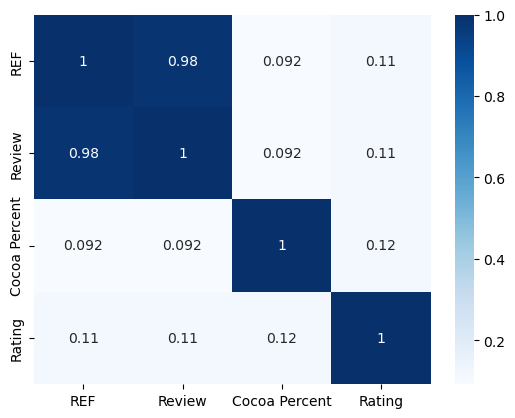

In [13]:
sns.heatmap(data.corr(), cmap='Blues', annot=True);

Видно, что столбец REF очень сильно коррелирует с Review.   
Это неудивительно, ведь REF - это "свежесть" записи, а Review - это дата публикации отзыва (год).   
Эти две колонки сообщают, по большому счету, одну и ту же информацию - возможно, имеет смысл выкинуть одну из них.    
Проверим эту идею позже   

Также можно отметить, что ни одна из переменных не имеет сильной корреляции с таргетом, что не очень хорошо

Теперь посмотрим на корреляцию категориальных переменных, используя V-меру Крамера

<Axes: >

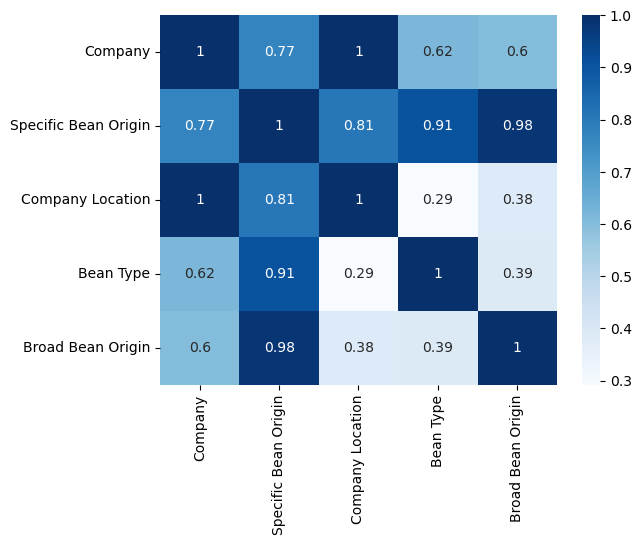

In [14]:
data_cat = data.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(data_cat)

sns.heatmap(cramersv.fit(), cmap='Blues', annot=True)

Как можем видеть, многие категориальные переменные коррелированы между собой.   
Это предсказуемо, так как определенная компания скорее всего, будет использовать какой-то определенный сорт какао-бобов,   
локация компаниии и ее название также взаимосвязаны - зная компанию, мы можем точно определить, в какой стране она расположена   
то же самое можно сказать и про сорт бобов и страну их происхождения     
Specific Bean Origin - это просто уточнение Broad Bean Origin   
Так как многие категориальные переменные сильно коррелированы между собой, возможно, также имеет смысл какие-то из них выкинуть - эту гипотезу также проверим позже

Теперь посмотрим на корреляцию категориальных признаков с таргетом, для этого используем дисперсионный анализ - ANOVA

In [15]:
from scipy.stats import f_oneway

tmp = []

for cat_col in data[cat_columns]:
    group_data = data.groupby(cat_col)['Rating'].apply(list)
    AnovaResults = f_oneway(*group_data)
    if AnovaResults[1] >= 0.05:
            tmp.append({'Category' : cat_col, 'Is correlated' : 'No'})
    else:
            tmp.append({'Category' : cat_col, 'Is correlated' : 'Yes'})

AnovaRes = pd.DataFrame.from_dict(tmp)
AnovaRes

,Category,Is correlated
0,Company,Yes
1,Specific Bean Origin,Yes
2,Company Location,Yes
3,Bean Type,Yes
4,Broad Bean Origin,Yes


Мы можем видеть, что все категориальные переменные коррелированы с таргетом, что хорошо

# Работа с пропущенными значениями

In [16]:
data.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               1
Broad Bean Origin       1
dtype: int64

Всего 2 пропущенных значения - просто выкинем эти строчки

In [17]:
data.dropna(inplace=True)

# Построение новых признаков

Во-первых, нам нужно закодировать категориальное переменные.    
Во-вторых, у нас есть несколько числовых переменных, и, возможно, какая-то линейная комбинация этих признаков хорошо скажется на качестве модели   
К тому же проверим гипотезу о том, что отбрасывание одной из переменных, отвечающих за "свежесть" отзыва, может хорошо сказаться на качестве модели.   
Для этого попробуем по очереди исключить из данных обе эти колонки и посмотреть на результат. Как модель возьмем lightgbm - катбуст долго ждать, кодировщик и скалер возьмем случайные - нам важна разница между моделями, а не их качество

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline

X = data.drop('Rating', axis=1)
y = data.Rating

pl = Pipeline([
    ('encoder_', TargetEncoder(cols=cat_columns)),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor())
])

scores_all_num = cross_val_score(pl, X, y, cv=3, scoring='r2').mean()

X_no_ref = X.drop('REF', axis=1)
scores_no_ref = cross_val_score(pl, X_no_ref, y, cv=3, scoring='r2').mean()

X_no_review = X.drop('Review', axis=1)
scores_no_review = cross_val_score(pl, X_no_review, y, cv=3, scoring='r2').mean()



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 835, number of used features: 8
[LightGBM] [Info] Start training from score 3.171257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise

In [19]:
print('all num features:', scores_all_num)
print('No REF:', scores_no_ref)
print('No Review:', scores_no_review)

all num features: 0.016864192098543136
No REF: 0.01539666884378769
No Review: 0.01832268285583849


Видно, что без Review модель отработала даже чуть лучше, чем на всех признаках.   
Значит, Review отбрасываем - гипотеза подтвердилась

In [20]:
X.drop('Review', axis=1, inplace=True)
X

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,0.72,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,0.72,Switzerland,,Venezuela
2,Dark Forest,Tanzania,1554,0.70,U.S.A.,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,0.72,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,0.75,France,Criollo,Indonesia
...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,0.80,U.K.,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,0.70,Peru,,Peru
1252,Arete,Nacional,1534,0.68,U.S.A.,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,0.72,U.S.A.,,Dominican Republic


Поделим данные для более точной проверки

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True)

Подберем базовый набор гиперпараметров, скалер и кодировщик пока возьмем случайные

In [22]:
import optuna 
from sklearn.preprocessing import MinMaxScaler

encoder = TargetEncoder(cols=cat_columns)
scaler = MinMaxScaler()

encoder.fit(X, y)

X_transformed = encoder.transform(X)


scaler.fit(X_transformed)
X_transformed = scaler.transform(X_transformed)

def objective_lgbm(trial):

    num_leaves = trial.suggest_int('num_leaves', 31, 350)
    max_depth = trial.suggest_int('max_depth', 2, 16)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 0.5, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 700)

    score = cross_val_score(LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, 
                                              n_estimators=n_estimators, cat_features=cat_columns),
                            X_transformed, y, cv=3, scoring='r2', n_jobs=8).mean()
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials=50)

[I 2023-09-28 16:59:05,217] A new study created in memory with name: no-name-a46fa16e-4af7-4ae8-adf2-d3d6daedf439
[I 2023-09-28 16:59:14,078] Trial 0 finished with value: 0.5880281490412191 and parameters: {'num_leaves': 73, 'max_depth': 4, 'learning_rate': 0.0028204806360304585, 'n_estimators': 435}. Best is trial 0 with value: 0.5880281490412191.
[I 2023-09-28 16:59:19,813] Trial 1 finished with value: 0.07418822541413635 and parameters: {'num_leaves': 91, 'max_depth': 9, 'learning_rate': 0.00013951213114516203, 'n_estimators': 441}. Best is trial 0 with value: 0.5880281490412191.
[I 2023-09-28 16:59:23,963] Trial 2 finished with value: 0.0113705531000996 and parameters: {'num_leaves': 75, 'max_depth': 10, 'learning_rate': 5.354266862640101e-05, 'n_estimators': 182}. Best is trial 0 with value: 0.5880281490412191.
[I 2023-09-28 16:59:24,391] Trial 3 finished with value: 0.0219044416655589 and parameters: {'num_leaves': 272, 'max_depth': 5, 'learning_rate': 6.702733137478383e-05, 'n_e

In [23]:
study.best_params, study.best_value

({'num_leaves': 32,
  'max_depth': 2,
  'learning_rate': 0.038573509302075225,
  'n_estimators': 565},
 0.6687157328357812)

На кросс-валидации все выглядит очень хорошо. Посмотрим на трейн-тест-сплите

In [27]:
from sklearn.metrics import r2_score

X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X_transformed, y, random_state=random_state)

model = LGBMRegressor(**study.best_params)

model.fit(X_train_tr, y_train_tr)

pred = model.predict(X_test_tr)

r2_score(y_test_tr, pred)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 939, number of used features: 7
[LightGBM] [Info] Start training from score 3.168530
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

0.6512126255458761

Отлично! Что имеем на данный момент:   
Модель: LightGBM, 'num_leaves': 276, 'max_depth': 4, 'learning_rate': 0.05072927684914718, 'n_estimators': 254   
Энкодер: TargetEncoder   
Скалер: MinMaxScaler   
r2 = 0.667   

Теперь попробуем еще что-то сделать с фичами   
Для начала посмотрим на важность признаков для нашей модели

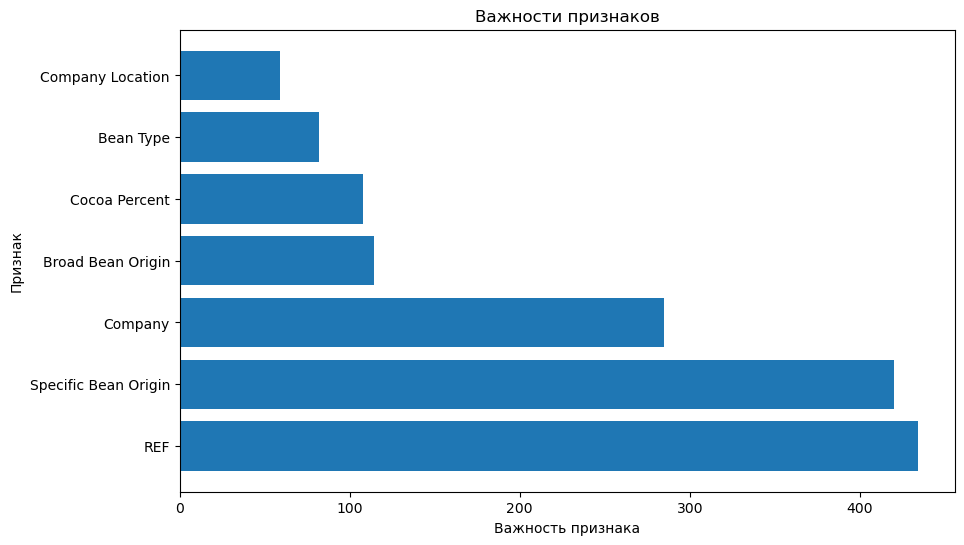

In [25]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], align='center')
plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важности признаков')
plt.show()

Попробуем PolynomialFeatures

In [26]:
from sklearn.preprocessing import PolynomialFeatures


pl = Pipeline([
    ('encoder_', TargetEncoder(cols=cat_columns)),
    ('scaler_', MinMaxScaler()),
    ('model_', LGBMRegressor(**study.best_params))
])


cross_val_score(pl, X, y, scoring='r2', verbose=2, cv=3).mean()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 835, number of used features: 7
[LightGBM] [Info] Start training from score 3.171257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 835, number of used features: 7
[LightGBM] [Info] Start training from score 3.183832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


0.07185516479193743